In [1]:
%matplotlib inline

本文讨论如何使用RNN来生成名字。程序的最终效果如下：

```bash
> python sample.py Russian RUS
Rovakov
Uantov
Shavakov

> python sample.py German GER
Gerren
Ereng
Rosher

> python sample.py Spanish SPA
Salla
Parer
Allan

> python sample.py Chinese CHI
Chan
Hang
Iun
```

与之前对名字进行分类有所不同，在这个实验中我们每次输入一个类别并得到一个字母。

# 准备数据

从[这里](https://download.pytorch.org/tutorial/data.zip)下载数据集并将其放置于当前文件夹下。

`data/name`文件夹包含了18个以“[语言].txt”命名的文件。每个文件包含一组名字，每个名字占一行。

我们将名字存在一个字典中：`{language: [names ...]}`。

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


# 创建网络

这个网络是对上一个教程中的网络的扩展。其输出是下一位置每个字符的概率，概率最大的字符被当做下一个字符。

将output和hidden结合后，将其输入了第二个线性层`o2o`。此外还增加了`dropout`来使输出变得多样。网络结构如下如所示。

![网络结构](https://i.imgur.com/jzVrf7f.png)

In [3]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# 训练

## 训练准备

首先定义随机获取(category, line)对的函数。

In [4]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

对于每个时间步，其输入为(category, current letter, hidden state)，其输出为(next letter, next hidden state)。所以，为了训练这个网络，我们需要准备相应格式的数据。

由于在每个时间步中，我们要根据当前的字符来预测下一个字符，我们将连续字符作为训练数据，如根据`"ABCD<EOS>"`我们得到("A","B"), ("B","C"), ("C","D"), ("D","EOS")。

![例子](https://i.imgur.com/JH58tXY.png)

category tensor是一个`<1 x n_category>`维的one-hot tensor。每个时间步将其输入到网络中。

In [5]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

为了简便，我们实现了`randomTrainingExample`函数来获取一个随机的(category, line)对，并将其转化为我们训练网络需要的格式。

In [6]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

## 训练网络

在分类任务中，只有得到最后的输出后，才能计算损失。而在此任务中，我们每一步都需要进行预测，因此，每一步都要计算损失。

In [7]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

为了记录训练时长，这里添加了`timeSince`函数。

In [8]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

然后开始训练吧。

In [9]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 15s (5000 5%) 3.1672
0m 31s (10000 10%) 2.8857
0m 47s (15000 15%) 2.0811
1m 3s (20000 20%) 3.7460
1m 18s (25000 25%) 2.1030
1m 34s (30000 30%) 2.9953
1m 49s (35000 35%) 3.3898
2m 5s (40000 40%) 2.7685
2m 21s (45000 45%) 3.4259
2m 36s (50000 50%) 2.3836
2m 52s (55000 55%) 2.4844
3m 8s (60000 60%) 2.9120
3m 24s (65000 65%) 3.2904
3m 40s (70000 70%) 2.2922
3m 56s (75000 75%) 2.6322
4m 12s (80000 80%) 2.9110
4m 27s (85000 85%) 2.0273
4m 42s (90000 90%) 2.8397
4m 58s (95000 95%) 3.1839
5m 14s (100000 100%) 2.1432


## 打印损失

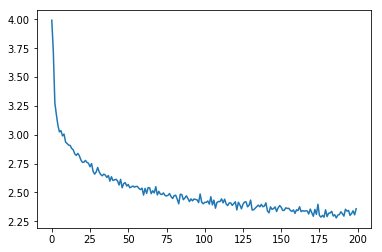

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# 从网络中采样

为了实现最终的目的，我们每次给网络一个字符，然后让网络输出下一个，知道EOS为止。具体步骤如下：

- Create tensors for input category, starting letter, and empty hidden state
- Create a string output_name with the starting letter
- Up to a maximum output length,
    - Feed the current letter to the network
    - Get the next letter from highest output, and next hidden state
    - If the letter is EOS, stop here
    - If a regular letter, add to output_name and continue
- Return the final name

In [11]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rover
Uarevev
Shantent
Gerter
Ering
Romer
Santer
Pare
Alla
Can
Han
Iha
